The problem that I would be solving is to recognize what part of the body is reflected and give the X-ray image of a specific body part. I would use a data set from https://www.kaggle.com/datasets/andrewmvd/medical-mnist. I will implement a two-layer neural network for this project. I think this project will be beneficial to the surgical robot field, because the surgical robot could input the images that it sees/scans, such as when its camera sees the human body, it automatically can do the X-Ray on that person, it’s more efficient than if it can identify which organ did it do the X-Ray on and organize it to a different category based on the organs. It will save doctors time reviewing each file and checking which organ is on the X-Ray report. I think ML/AI can solve this problem because ML/AI can train the data, and learn from the data. In my case, my ML model will train the input medical Mnist data set, learn the pattern, and become able to identify the input image.


Problem statement: classifying a given x-ray image into a category (either Abdomen CT,Breast MRI,Chest CT,CXR, Hand, or Head CT)

In [69]:
import random
from matplotlib import pyplot
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from shutil import copy2
import keras.layers as layers
from shutil import copyfile
from keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from numpy import std
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [15]:
pwd

'/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project'

In [27]:
parent_dir = Path('/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data')
xray_classes = ["AbdomenCT","BreastMRI","ChestCT","CXR","Hand","HeadCT"]

AbdomenCT = [fn for fn in os.listdir(f'{parent_dir}/AbdomenCT') if fn.endswith('.jpeg')]
BreastMRI = [fn for fn in os.listdir(f'{parent_dir}/BreastMRI') if fn.endswith('.jpeg')]
ChestCT = [fn for fn in os.listdir(f'{parent_dir}/ChestCT') if fn.endswith('.jpeg')]
CXR = [fn for fn in os.listdir(f'{parent_dir}/CXR') if fn.endswith('.jpeg')]
Hand = [fn for fn in os.listdir(f'{parent_dir}/Hand') if fn.endswith('.jpeg')]
HeadCT = [fn for fn in os.listdir(f'{parent_dir}/HeadCT') if fn.endswith('.jpeg')]

all = [AbdomenCT,BreastMRI,ChestCT,CXR,Hand,HeadCT]

training_dir_path=[f'/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/training/{a}' for a in xray_classes]
validation_dir_path=[f'/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/validation/{a}' for a in xray_classes]
testing_dir_path=[f'/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/testing/{a}' for a in xray_classes]
source_path=[f'/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/{a}' for a in xray_classes]

** Exploratory Data Analysis **

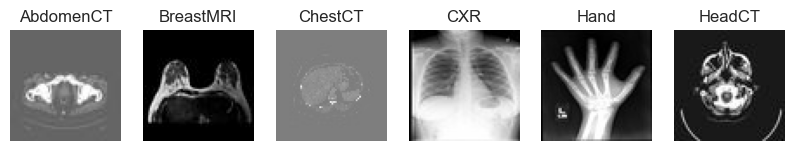

In [28]:
plt.figure(figsize=(10,10))
i=1
for label in xray_classes:
    plt.subplot(1, 6, i)
    file = random.choice(os.listdir(f'{parent_dir}/{label}'))
    image_path = os.path.join(f'{parent_dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')
    i+=1

Total images: 58954
Total class: 6


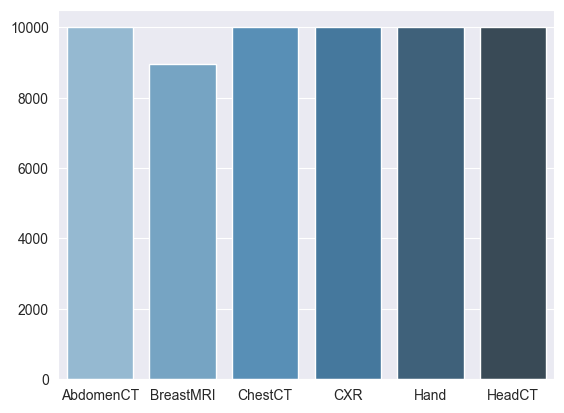

In [29]:
total = 0
for i in all:
  for j in i:
    total+=1

print("Total images: {}".format(total))
print("Total class: 6")

count = []
for i in range(len(xray_classes)):
  count.append(len(all[i]))
sns.set_style('darkgrid')
sns.barplot(x=xray_classes, y=count, palette="Blues_d")
plt.show()

As we can see the number of images are the same except for the Breast MRI.

Image dimensions: (64, 64, 3)


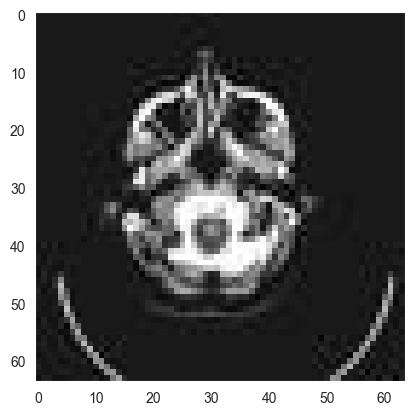

In [30]:
sample_img = cv2.imread(image_path)
plt.imshow(sample_img)
plt.grid(None)
print(f'Image dimensions: {sample_img.shape}')

In [33]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
    files = []
#print(SOURCE)
    for filename in os.listdir(SOURCE):
    
        file = SOURCE +'/'+ filename
        if os.path.getsize(file) > 0:
            files.append(filename)

    training_length = int( len(files)* SPLIT_SIZE)
    validation_length = int(len(files) * 0.10)
    testing_length = int(len(files) - training_length - validation_length)

    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:(training_length+validation_length)]
    testing_set=shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE +'/'+ filename
        destination = TRAINING +'/'+ filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE+'/'+filename
        destination =  TESTING+'/'+ filename
        copyfile(this_file, destination)
    
    for filename in validation_set:
        this_file = SOURCE +'/'+ filename
        destination = VALIDATION +'/' + filename
        copyfile(this_file, destination)


split_size = 0.85

In [36]:
for source,train_dir_path,val_dir_path,test_dir_path in zip(source_path,\
                                training_dir_path,validation_dir_path, testing_dir_path):
   
    split_data(source,train_dir_path,val_dir_path,test_dir_path, split_size)

I will use data augmentation as my regularization method because it can reduce the cost of collecting, labelling data, and overfitting. Also, it can increase the accuracy of the classifying the x-ray images by transforming the images and creating more unique samples.

In [38]:
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                    rotation_range=60,
                                width_shift_range=0.4,
                                 height_shift_range=0.4,
                                   zoom_range=0.2,
                                  brightness_range=[0.5,2],
                                     shear_range=0.2,
                                 horizontal_flip=True,
                                    fill_mode='nearest'
                                   )
                                   
datagen = ImageDataGenerator(rescale=1./255)


In [44]:
train = train_datagen.flow_from_directory(directory= '/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/training',
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(150, 150)
                                                       )

test = datagen.flow_from_directory(directory= '/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/testing',
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(150, 150)
                                                       )

validation = datagen.flow_from_directory(directory= '/Users/janezou/Desktop/school/Fall 2022/CSCI-4962/project/data/validation',
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(150, 150)
                                                       )   
                                              

Found 50110 images belonging to 6 classes.
Found 2949 images belonging to 6 classes.
Found 5895 images belonging to 6 classes.


0.0 0.40359095 1.0


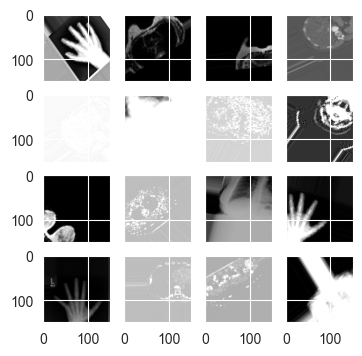

In [79]:
#show the result of data augmentation
for X_batch, y_batch in train:
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 4x4 images
    fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(4,4))
    
    for i in range(4):
        for j in range(4):
            ax[i][j].imshow(X_batch[i*4+j], cmap=plt.get_cmap("gray"))
    plt.show()
    break

In [55]:
# implementing the CNN model
model = tf.keras.Sequential()  
model.add(layers.Conv2D(32,  activation='relu', kernel_size=(5, 5),input_shape=(150,150,3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#dense layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 39200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 39200)            

In [52]:
model_fit= model.fit(train,validation_data= validation, epochs=10, batch_size=128)

Epoch 1/10
392/392 [==============================] - 621s 2s/step - loss: 0.0598 - accuracy: 0.9796 - val_loss: 0.0151 - val_accuracy: 0.9954
Epoch 2/10
392/392 [==============================] - 624s 2s/step - loss: 0.0621 - accuracy: 0.9785 - val_loss: 0.0388 - val_accuracy: 0.9864
Epoch 3/10
392/392 [==============================] - 519s 1s/step - loss: 0.0397 - accuracy: 0.9860 - val_loss: 0.0110 - val_accuracy: 0.9971
Epoch 4/10
392/392 [==============================] - 518s 1s/step - loss: 0.0316 - accuracy: 0.9898 - val_loss: 0.0111 - val_accuracy: 0.9961
Epoch 5/10
392/392 [==============================] - 554s 1s/step - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0143 - val_accuracy: 0.9963
Epoch 6/10
392/392 [==============================] - 10020s 26s/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0076 - val_accuracy: 0.9976
Epoch 7/10
392/392 [==============================] - 658s 2s/step - loss: 0.0330 - accuracy: 0.9892 - val_loss: 0.0089 - val_accuracy: 0.9

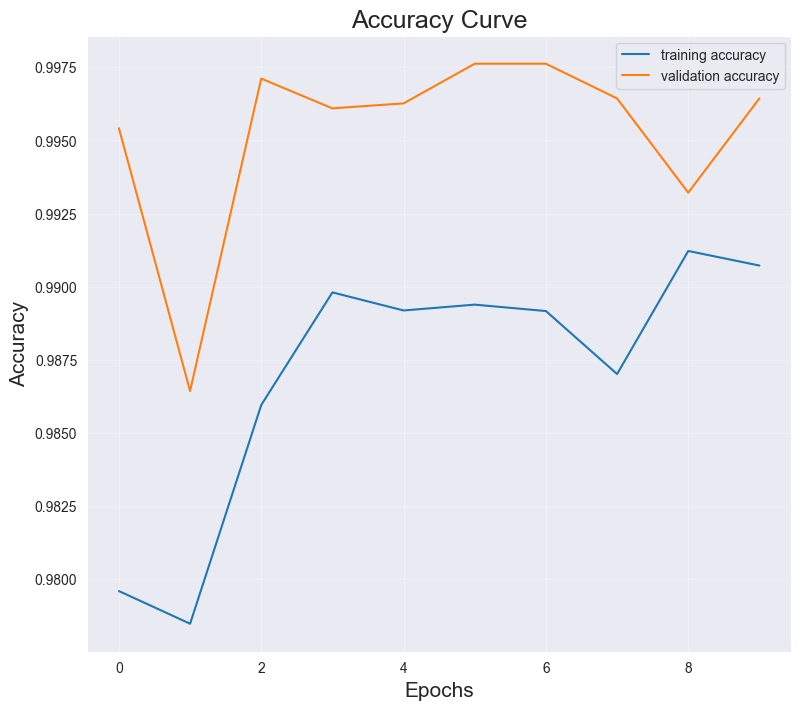

In [53]:
#create the accuracy curve graph
graph = plt.figure(figsize=(20,8))
graph.add_subplot(121)

plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "validation accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

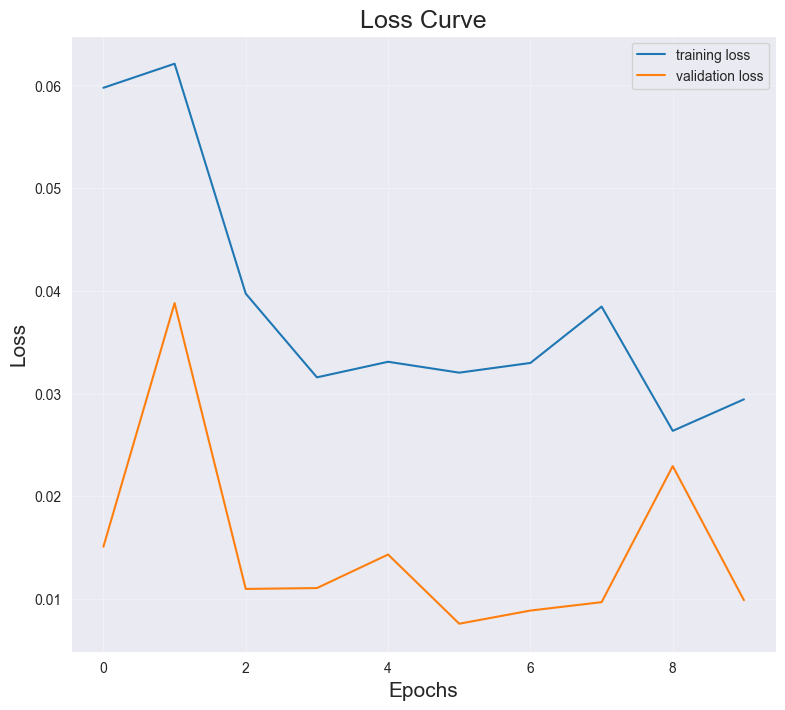

In [54]:
#create the loss graph
graph2 = plt.figure(figsize=(20,8))
graph2.add_subplot(121)

plt.plot(model_fit.epoch,model_fit.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_loss'],label="validation loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

There are 2 convolutional and pooling layers in my model. I added the dropout on the dense layers because I want to prevent the problem of overfitting. I choose relu activation as my activation function because the variables can interact with each other in this activation. The kernel size for convolutioanl layer are 5x5 and 3x3 , because I want to limiting the number of unrelated features possible. 
For the last output layer, I choose softmax activation with 6 neurons because there are 6 classes of x-ray images in my dataset, the softmax activation can normalize the output of a network to a probability distribution over predicted output. For the loss function, I used categorial cross entropy because it can measure the performance of a multi-class classification model. I used mini-batch to train my model because it has stable convergence.
I used Adam as my optimizer because it's more efficient than other optimizer in my data. It's like the combination of momentum and RMSP method. It uses the squared gradients to scale the learning rate and uses moving average of the gradient. Thus, It's good with sparse data, most consistent convergence, and it has faster computation time.

In conclusion, the CNN model that I implemented for classifying the x-ray image is efficient. It has very high training accuracy and validation accuracy. The loss is decreasing over the epochs, which indicates that the model's prediction is getting more precise over the time.